In [44]:
import numpy as np
import matplotlib.pyplot as plt
import interneuron_amb
import stellate
from scipy import signal,optimize,stats
import phase_prec_hf as hf_p
import seaborn as sns
import sim_utils as s_utils
from neuron import h

h.load_file("stdrun.hoc")
h.celsius = 37
h.cvode.active(1)
import importlib
import analysis_utils as a_utils
importlib.reload(interneuron_amb)
importlib.reload(stellate)

<module 'stellate' from '/home/govind/gov_semproject/GridCellsTheta/GridCellsCond/stellate.py'>

In [ ]:

stellate_0 = stellate.Stellate(0)
global_intrnrn = interneuron_amb.Interneuron(1)

gs_weight = 5.0
gs_inh_gmax = 2e-3  # uS
sg_weight = 1.0
sg_exc_gmax = 0.1e-2  # uS

nc_gs = h.NetCon(global_intrnrn.soma(0.5)._ref_v, stellate_0.inhb_syn, sec=global_intrnrn.soma)
nc_gs.weight[0] = gs_weight * gs_inh_gmax 

nc_sg = h.NetCon(stellate_0.soma(0.5)._ref_v, global_intrnrn.exc_syn, sec=stellate_0.soma)
nc_sg.weight[0] = sg_weight * sg_exc_gmax

theta_ic = h.IClamp(global_intrnrn.soma(0.5))
theta_ic.dur = 1e9
freq = 8
time_ms = 1000
osc_amp = 5e-5
T, num_steps = time_ms/1000,time_ms

stell_ic = h.IClamp(stellate_0.soma(0.5))
stell_ic.dur = 1e9  
stell_ic.amp = 1e-3

time_arr = np.linspace(0,T,num_steps)
init_phase = np.pi/2
curr_arr = osc_amp * np.sin(2 * np.pi * freq * time_arr + init_phase)

curr_vec = h.Vector(curr_arr)
curr_vec.play(theta_ic._ref_amp, True)

spike_times = h.Vector()

nc = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
nc.threshold = 0
nc.record(spike_times)




0.0

15601


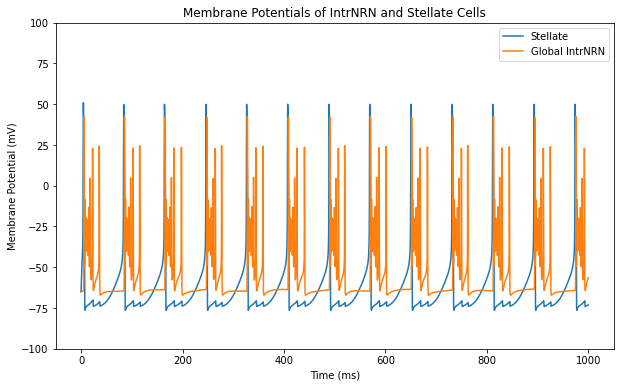

In [40]:
i_theta = h.Vector().record(theta_ic._ref_amp)

stellate_v = h.Vector().record(stellate_0.soma(0.5)._ref_v)
global_intrnrn_v = h.Vector().record(global_intrnrn.soma(0.5)._ref_v)
time = h.Vector().record(h._ref_t)


h.finitialize(-65)
h.continuerun(1000)
print(len(time.to_python()))
fig,ax = plt.subplots(figsize=(10,6))
#ax1 = ax.twinx()

ax.plot(time, stellate_v, label='Stellate')
ax.plot(time, global_intrnrn_v, label='Global IntrNRN')
##ax1.eventplot(spike_times, lineoffsets=-80, colors='r', linelengths=5, label='Stellate Spikes')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane Potential (mV)')
ax.set_title('Membrane Potentials of IntrNRN and Stellate Cells')
plt.legend()
plt.ylim(-100,100)
plt.show()



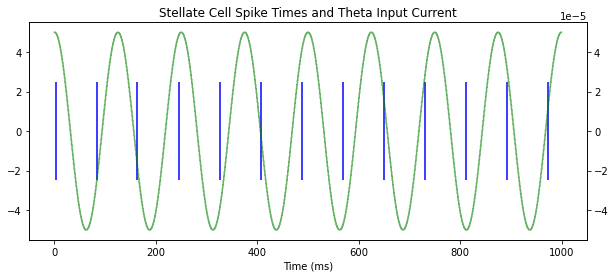

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))
ax1 = ax.twinx()

ax1.plot(time, i_theta.to_python(), color='g', alpha=0.6)
ax.eventplot(spike_times, lineoffsets=0, colors='blue', linelengths=5)
ax.set_xlabel('Time (ms)')
ax.set_title('Stellate Cell Spike Times and Theta Input Current')
plt.show()
    

In [36]:
print(len(spike_times.to_python()))

13


[3.03688654 3.17642653 3.29618041 3.43696208 3.56196189 3.71432531
 3.86683113 4.00325023 4.20583375 4.30989225 4.57888379 4.90309429
 4.95760303]


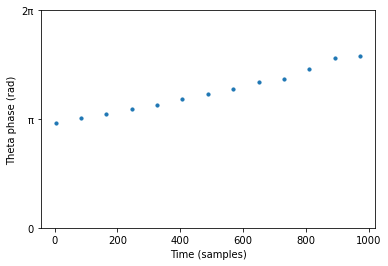

In [42]:
def vectorized_convert_angle(angles):
    return np.mod(angles, 2 * np.pi)

def calc_phase_single_stell(spike_idx, theta_signal):


    spike_idx = np.asarray(spike_idx)
    spike_idx = spike_idx[(spike_idx >= 0) & (spike_idx < len(theta_signal))]
    spike_idx = np.round(spike_idx).astype(int)

    analytic_signal = signal.hilbert(-np.array(theta_signal))
    instantaneous_phase = np.angle(analytic_signal)
    """
    Parameters
    ----------
    spike_idx : array-like
        Spike indices (NOT times)
    theta_signal : array-like
        Band-limited theta signal

    Returns
    -------
    spike_idx : np.ndarray
        Spike indices
    spike_phases : np.ndarray
        Theta phase at spike times in [0, 2π)
    """
    spike_phases = vectorized_convert_angle(
        instantaneous_phase[spike_idx]
    )

    return spike_idx, spike_phases

spike_idx, spike_phases = calc_phase_single_stell(
    spike_idx=spike_times,      # indices
    theta_signal=i_theta         # theta current
)
print(spike_phases)
first_phase = spike_phases[0]

plt.figure()
plt.scatter(spike_idx, spike_phases, s=10)
plt.xlabel("Time (samples)")
plt.ylabel("Theta phase (rad)")
plt.yticks([0, np.pi, 2*np.pi], ['0', 'π', '2π'])
plt.show()



[3.03688654 3.17513837 3.29508204 3.44583541 3.56074668 3.71432454
 3.86683113 4.00325023 4.2079949  4.30994162 4.58215619 4.90309429
 4.95760303]


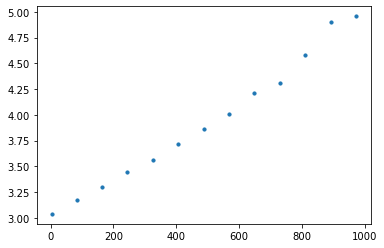

In [43]:
spike_arr = np.array(spike_times.to_python())
spike_idx = np.array(spike_arr).astype(int)

analytic_signal = signal.hilbert(-i_theta)
instantaneous_phase = np.angle(analytic_signal)
stell_phase = vectorized_convert_angle(instantaneous_phase)
print(stell_phase[spike_idx])
plt.scatter(spike_idx, stell_phase[spike_idx], s=10)




In [140]:
theta = i_theta.to_python()

print(type(theta))
print(np.asarray(theta).shape)
print(theta)

<class 'list'>
(15224,)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878

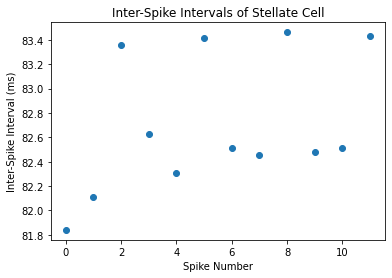

In [152]:
isi_array = np.diff(spike_times.to_python())    
plt.scatter(range(len(isi_array)), isi_array)
plt.xlabel('Spike Number') 
plt.ylabel('Inter-Spike Interval (ms)')
plt.title('Inter-Spike Intervals of Stellate Cell')
plt.show()                         

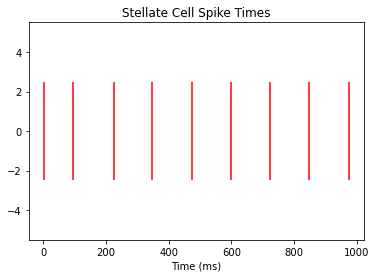

In [7]:
plt.eventplot(spike_times, lineoffsets=0, colors='r', linelengths=5)
plt.xlabel('Time (ms)')
plt.title('Stellate Cell Spike Times')
plt.show()

In [ ]:
stell_spikes_l = spike_times